In [24]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, Layer, LayerNormalization
from keras.models import Model
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K

In [25]:
# 시드 고정
import random

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [26]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
M1 = 8
M2 = 4

k1 = np.log2(M1)
k1 = int(k1)

k2 = np.log2(M2)
k2 = int(k2)

n_channel = 1

R1 = k1/n_channel
R2 = k2/n_channel

print ('M1:',M1,'k1:',k1,'n:',n_channel)
print ('M1:',M2,'k1:',k2,'n:',n_channel)

M1: 8 k1: 3 n: 1
M1: 4 k1: 2 n: 1


In [27]:
import numpy as np
from commpy.channelcoding import Trellis, conv_encode, viterbi_decode
from commpy.utilities import bitarray2dec

# Trellis 생성 (m=6일 경우)
trellis = Trellis(np.array([7]), np.array([[171, 133]]))
tbl = 32

def bitarray_to_decimal(bit_array, bits_per_symbol):
    # 비트를 bits_per_symbol 비트씩 나누고, 각 조각을 십진수로 변환
    n_symbols = len(bit_array) // bits_per_symbol
    decimal_symbols = []
    for i in range(n_symbols):
        # 비트 조각 가져오기
        bit_slice = bit_array[i * bits_per_symbol:(i + 1) * bits_per_symbol]
        # 십진수로 변환
        decimal_value = bitarray2dec(bit_slice)
        decimal_symbols.append(decimal_value)
    return np.array(decimal_symbols)

def decimal_to_bitarray(decimal_array, bits_per_symbol):
    bit_array = np.concatenate([np.array(list(np.binary_repr(d, width=bits_per_symbol)), dtype=int) for d in decimal_array])
    return bit_array

## Train data

In [28]:
# #generating data of size N
N = 160000
label1 = np.random.randint(M1,size=N)
label2 = np.random.randint(M2,size=N)

In [29]:
# creating one hot encoded vectors
data1 = []
for i in label1:
    temp = np.zeros(M1)
    temp[i] = 1
    data1.append(temp)

data2 = []
for i in label2:
    temp = np.zeros(M2)
    temp[i] = 1
    data2.append(temp)

In [30]:
data1 = np.array(data1)

print (data1.shape)

data2 = np.array(data2)

print (data2.shape)

(160000, 8)
(160000, 4)


In [31]:
# Functions that define the Channel. 

# First the encoder output must be converted to complex samples 
# Right now I am assuming n = 1 for simplicity

def real_to_complex(x):
    real = x[:,0]
    imag = x[:,1]
    return tf.reshape(tf.dtypes.complex(real,imag),shape=[-1,1])

def complex_to_real(x):
    real = tf.math.real(x)
    imag = tf.math.imag(tf.dtypes.cast(x,tf.complex64))
    real_expand = tf.expand_dims(real,-1)
    imag_expand = tf.expand_dims(imag,-1)
    concated = tf.concat([real_expand, imag_expand],-1)
    return tf.reshape(concated,shape=[-1,2])

In [32]:
def reyleigh_single_tap_train(x, SNRdB):
    
    EbNo=10.0**(-SNRdB/10.0)
    
    # Rayleigh 페이딩 채널의 실수 및 허수 부분 생성
    h_real = 1/np.sqrt(2) * K.random_normal((n_channel,), mean=0, stddev=1)
    h_imag = 1/np.sqrt(2) * K.random_normal((n_channel,), mean=0, stddev=1)
    h = tf.dtypes.complex(h_real, h_imag)
    
    # 복합 AWGN 노이즈 생성
    noise_real = np.sqrt(EbNo)/np.sqrt(2) * K.random_normal((n_channel,), mean=0, stddev=1)
    noise_imag = np.sqrt(EbNo)/np.sqrt(2) * K.random_normal((n_channel,), mean=0, stddev=1)
    noise = tf.dtypes.complex(noise_real, noise_imag)

    # Rayleigh 페이딩 채널을 통해 전송된 신호
    chan = tf.dtypes.cast(x, tf.complex64) + noise / h

    return chan


def reyleigh_single_tap(signal, EbNo, nrow, ncol):

    signal = signal[:,0] + 1j * signal[:,1]
    
    signal = signal.reshape(nrow, ncol)
    
    # 복소수 채널 1과 채널 2를 한 번에 생성
    h = (1/np.sqrt(2)) * (np.random.randn(nrow, ncol) + 1j * np.random.randn(nrow, ncol))

    # 복소수 가우시안 노이즈 생성
    noise = (np.sqrt(EbNo)/np.sqrt(2)) * (np.random.randn(nrow, ncol) + 1j * np.random.randn(nrow, ncol))

    chan = signal + (noise / h)
    
    chan_real = np.real(chan)
    chan_imag = np.imag(chan)
    chan_split = np.stack((chan_real, chan_imag), axis=1).squeeze()

    
    return chan_split

def awgn_single_tap_train(x, SNRdB):
    
    EbNo=10.0**(-SNRdB/10.0)
    
    # 복합 AWGN 노이즈 생성
    noise_real = np.sqrt(EbNo)/np.sqrt(2) * K.random_normal((n_channel,), mean=0, stddev=1)
    noise_imag = np.sqrt(EbNo)/np.sqrt(2) * K.random_normal((n_channel,), mean=0, stddev=1)
    noise = tf.dtypes.complex(noise_real, noise_imag)

    # Rayleigh 페이딩 채널을 통해 전송된 신호
    chan = tf.dtypes.cast(x, tf.complex64) + noise
    
    return chan

def awgn_single_tap(signal, EbNo, nrow, ncol):

    signal = signal[:,0] + 1j * signal[:,1]
    
    signal = signal.reshape(nrow, ncol)
    
    # 복소수 가우시안 노이즈 생성
    noise = (np.sqrt(EbNo)/np.sqrt(2)) * (np.random.randn(nrow, ncol) + 1j * np.random.randn(nrow, ncol))

    chan = signal + noise
    
    chan_real = np.real(chan)
    chan_imag = np.imag(chan)
    chan_split = np.stack((chan_real, chan_imag), axis=1).squeeze()
    
    return chan_split

In [33]:
class AveragePowerNormalize(Layer):
    def __init__(self, **kwargs):
        super(AveragePowerNormalize, self).__init__(**kwargs)

    def call(self, inputs):
        # 각 배치별 평균 전력을 계산
        normalization_factor = K.sqrt(K.mean(K.square(inputs)))
        
        # 원본 입력을 그대로 유지하면서 정규화
        return inputs / normalization_factor

# AutoEncoder

In [34]:
# Transmitter Layer
input_signal1 = Input(shape=(M1,))
input_signal2 = Input(shape=(M2,))

encoded1 = Dense(M1, activation='relu')(input_signal1)
encoded1_1 = Dense(2 * n_channel, activation='linear')(encoded1)
encoded1_2 = BatchNormalization()(encoded1_1)
# encoded1_3 = Lambda(lambda x: K.l2_normalize(x, axis=-1))(encoded1_2)
encoded1_3 = AveragePowerNormalize()(encoded1_2)


encoded2 = Dense(M2, activation='relu')(input_signal2)
encoded2_1 = Dense(2 * n_channel, activation='linear')(encoded2)
encoded2_2 = BatchNormalization()(encoded2_1)
# encoded2_3 = Lambda(lambda x: K.l2_normalize(x, axis=-1))(encoded2_2)
encoded2_3 = AveragePowerNormalize()(encoded2_2)

# Reyleigh Channel Layer
SNRdB = 30
channel_in1 = Lambda(real_to_complex)(encoded1_3)
channel_in2 = Lambda(real_to_complex)(encoded2_3)
channel1 = reyleigh_single_tap_train(channel_in1, SNRdB)
channel2 = reyleigh_single_tap_train(channel_in2, SNRdB)
channel_out1 = Lambda(complex_to_real)(channel1)
channel_out2 = Lambda(complex_to_real)(channel2)

# Reciever Layer
decoded1 = Dense(M1, activation='relu')(channel_out1)
decoded1_1 = Dense(M1, activation='softmax')(decoded1)

# Reciever Layer
decoded2 = Dense(M2, activation='relu')(channel_out2)
decoded2_1 = Dense(M2, activation='softmax')(decoded2)

# 모델 생성 및 컴파일
autoencoder = Model([input_signal1, input_signal2], [decoded1_1, decoded2_1])
adam = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')


In [35]:
print(autoencoder.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 8)                    72        ['input_5[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 4)                    20        ['input_6[0][0]']             
                                                                                            

# TRAIN

In [36]:
# traning auto encoder
autoencoder.fit([data1, data2], [data1, data2],
                epochs=45,
                batch_size=32)

Epoch 1/45
5000/5000 [==============================] - 3s 417us/step - loss: 1.8426 - dense_13_loss: 1.1970 - dense_15_loss: 0.6456
Epoch 2/45
5000/5000 [==============================] - 2s 415us/step - loss: 0.6762 - dense_13_loss: 0.4508 - dense_15_loss: 0.2255
Epoch 3/45
5000/5000 [==============================] - 2s 424us/step - loss: 0.2804 - dense_13_loss: 0.1750 - dense_15_loss: 0.1054
Epoch 4/45
   1/5000 [..............................] - ETA: 3s - loss: 0.2627 - dense_13_loss: 0.1853 - dense_15_loss: 0.0774

KeyboardInterrupt: 

# TEST

### Encoder

In [37]:
# making encoder from full autoencoder
encoder = Model([input_signal1, input_signal2], [encoded1_3, encoded2_3])

### Decoder

In [38]:
# making decoder from full autoencoder
encoded_input1 = Input(shape=(2 * n_channel,))
encoded_input2 = Input(shape=(2 * n_channel,))

deco1 = autoencoder.layers[-4](encoded_input1)
deco1 = autoencoder.layers[-2](deco1)

deco2 = autoencoder.layers[-3](encoded_input2)
deco2 = autoencoder.layers[-1](deco2)

decoder = Model([encoded_input1, encoded_input2], [deco1, deco2])

### Convolution Code test data

In [39]:
N = 5000

# test data conv1
log2M1 = int(np.log2(M1))
test_userBit1 = np.random.randint(0, 2, N * log2M1)

test_userBit1_Conv = conv_encode(test_userBit1, trellis)

test_userBit1_Conv = test_userBit1_Conv[:2 * len(test_userBit1)]

test_userData1 = bitarray_to_decimal(test_userBit1_Conv, log2M1)  # 부호화된 심볼을 십진수로 변환

test_conv_data1 = []

for i in test_userData1:
    temp = np.zeros(M1)
    temp[i] = 1
    test_conv_data1.append(temp)

test_conv_data1 = np.array(test_conv_data1)


# test data conv2
log2M2 = int(np.log2(M2))
test_userBit2 = np.random.randint(0, 2, N * log2M2)

test_userBit2_Conv = conv_encode(test_userBit2, trellis)

test_userBit2_Conv = test_userBit2_Conv[:2 * len(test_userBit2)]

test_userData2 = bitarray_to_decimal(test_userBit2_Conv, log2M2)  # 부호화된 심볼을 십진수로 변환

test_conv_data2 = []

for i in test_userData2:
    temp = np.zeros(M2)
    temp[i] = 1
    test_conv_data2.append(temp)

test_conv_data2 = np.array(test_conv_data2)

### test data

In [40]:
# generating data for checking BER
# if you're not using t-sne for visulation than set N to 70,000 for better result 
# for t-sne use less N like N = 1500

# test data1
test_label1 = np.random.randint(M1,size=N)
test_data1 = []

for i in test_label1:
    temp = np.zeros(M1)
    temp[i] = 1
    test_data1.append(temp)

test_data1 = np.array(test_data1)

# test data2
test_label2 = np.random.randint(M2,size=N)
test_data2 = []

for i in test_label2:
    temp = np.zeros(M2)
    temp[i] = 1
    test_data2.append(temp)

test_data2 = np.array(test_data2)

157/157 [==============================] - 0s 243us/step
Encoded Signal 1 Average Power: 4.5099306
Encoded Signal 2 Average Power: 4.11539


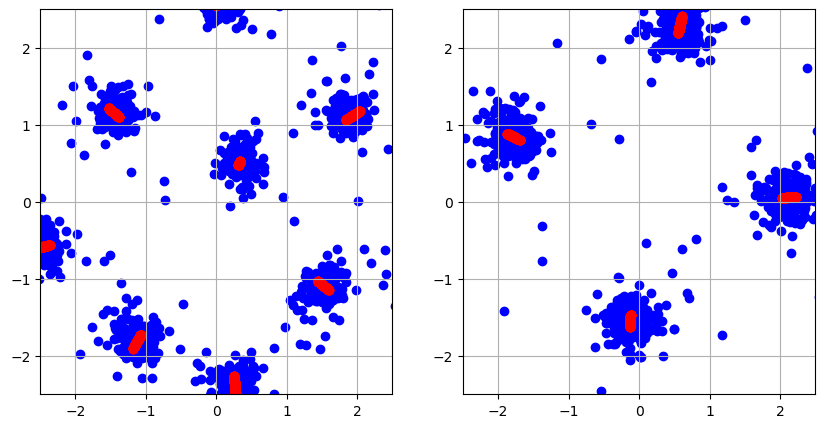

In [42]:
SNRdB = 23
EbNo = 10.0**(-SNRdB / 10.0)
# Predict encoded signal
encoded_signal1, encoded_signal2  = encoder.predict([test_data1, test_data2])

# Pass through Rayleigh channel
final_signal1 = reyleigh_single_tap(encoded_signal1, EbNo, N, n_channel)
final_signal2 = reyleigh_single_tap(encoded_signal2, EbNo, N, n_channel)

# Predict the output
pred_final_signal1, pred_final_signal2 = decoder.predict([final_signal1, final_signal2])

# 평균 전력 확인
power1 = np.mean(np.sum(np.abs(encoded_signal1)**2, axis=1))
power2 = np.mean(np.sum(np.abs(encoded_signal2)**2, axis=1))
print('Encoded Signal 1 Average Power:', power1)
print('Encoded Signal 2 Average Power:', power2)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(final_signal1[:,0], final_signal1[:,1], color = 'blue')
plt.scatter(encoded_signal1[:,0],encoded_signal1[:,1], color = 'red')
plt.grid()
plt.axis((-2.5, 2.5, -2.5, 2.5))
plt.subplot(1, 2, 2)
plt.scatter(final_signal2[:,0], final_signal2[:,1], color = 'blue',)
plt.scatter(encoded_signal2[:,0],encoded_signal2[:,1], color = 'red')
plt.axis((-2.5, 2.5, -2.5, 2.5))
plt.grid()

In [19]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

## Convolution Simulation

In [20]:
import numpy as np

# BER Calculation
EbNodB_range = list(frange(0, 21, 2))
ber1_conv = [None] * len(EbNodB_range)
ber2_conv = [None] * len(EbNodB_range)
num_bits1 = int(np.log2(M1))
num_bits2 = int(np.log2(M2))
conv_R = trellis.k / trellis.n

for n in range(len(EbNodB_range)):
    EbNo = 10.0**(-EbNodB_range[n] / 10.0)
    nn = N

    # Predict encoded signal
    encoded_signal1, encoded_signal2 = encoder.predict([test_conv_data1, test_conv_data2])
    
    # Pass through Rayleigh channel
    final_signal1 = reyleigh_single_tap(encoded_signal1, EbNo, int(nn / conv_R), n_channel)
    final_signal2 = reyleigh_single_tap(encoded_signal2, EbNo, int(nn / conv_R), n_channel)

    # Predict the output
    pred_final_signal1, pred_final_signal2 = decoder.predict([final_signal1, final_signal2])

    # Convert predictions to symbol indices (0 to M-1)
    pred_output1 = np.argmax(pred_final_signal1, axis=1)
    pred_output2 = np.argmax(pred_final_signal2, axis=1)

    pred_output_bits1 = decimal_to_bitarray(pred_output1, log2M1)
    pred_output_bits2 = decimal_to_bitarray(pred_output2, log2M2)
    
    pred_output_bits1 = viterbi_decode(pred_output_bits1, trellis, tb_depth=tbl)
    pred_output_bits2 = viterbi_decode(pred_output_bits2, trellis, tb_depth=tbl)

    # Calculate bit errors
    bit_errors1 = np.sum(pred_output_bits1 != test_userBit1)
    bit_errors2 = np.sum(pred_output_bits2 != test_userBit2)

    # Calculate BER
    ber1_conv[n] = bit_errors1 / (nn * num_bits1)
    ber2_conv[n] = bit_errors2 / (nn * num_bits2)

    print('SNR:', EbNodB_range[n], 'BER:', ber1_conv[n], ber2_conv[n])

313/313 [==============================] - 0s 233us/step
SNR: 0 BER: 0.1348 0.0008
313/313 [==============================] - 0s 230us/step
SNR: 2 BER: 0.05586666666666667 0.0002
313/313 [==============================] - 0s 231us/step
SNR: 4 BER: 0.016666666666666666 0.0002
313/313 [==============================] - 0s 231us/step
SNR: 6 BER: 0.0044666666666666665 0.0
313/313 [==============================] - 0s 230us/step
SNR: 8 BER: 0.0009333333333333333 0.0
313/313 [==============================] - 0s 231us/step
SNR: 10 BER: 0.0004 0.0
313/313 [==============================] - 0s 230us/step
SNR: 12 BER: 0.00013333333333333334 0.0
313/313 [==============================] - 0s 232us/step
SNR: 14 BER: 0.00013333333333333334 0.0
313/313 [==============================] - 0s 231us/step
SNR: 16 BER: 0.0 0.0
313/313 [==============================] - 0s 233us/step
SNR: 18 BER: 0.0 0.0
313/313 [==============================] - 0s 232us/step
SNR: 20 BER: 6.666666666666667e-05 0.0


## Simulation

In [21]:
import numpy as np

def symbols_to_bits(symbols, M):
    # Determine the number of bits required to represent the symbols (log2(M))
    num_bits = int(np.log2(M))
    
    # Convert each symbol to its binary representation and pad with leading zeros
    bit_array = np.array([np.binary_repr(symbol, width=num_bits) for symbol in symbols])
    
    # Flatten the array into a single array of bits (0 or 1)
    bit_array_flat = np.array([int(bit) for bits in bit_array for bit in bits])
    
    return bit_array_flat

# BER Calculation
EbNodB_range = list(frange(0, 21, 2))
ber1 = [None] * len(EbNodB_range)
ber2 = [None] * len(EbNodB_range)
num_bits1 = int(np.log2(M1))
num_bits2 = int(np.log2(M2))

for n in range(len(EbNodB_range)):
    EbNo = 10.0**(-EbNodB_range[n] / 10.0)
    nn = N

    # Predict encoded signal
    encoded_signal1, encoded_signal2 = encoder.predict([test_data1, test_data2])
    
    # Pass through Rayleigh channel
    final_signal1 = reyleigh_single_tap(encoded_signal1, EbNo, nn, n_channel)
    final_signal2 = reyleigh_single_tap(encoded_signal2, EbNo, nn, n_channel)

    # Predict the output
    pred_final_signal1, pred_final_signal2 = decoder.predict([final_signal1, final_signal2])

    # Convert predictions to symbol indices (0 to M-1)
    pred_output1 = np.argmax(pred_final_signal1, axis=1)
    pred_output2 = np.argmax(pred_final_signal2, axis=1)

    pred_output_bits1 = symbols_to_bits(pred_output1, M1)
    pred_output_bits2 = symbols_to_bits(pred_output2, M2)

    test_label_bits1 = symbols_to_bits(test_label1, M1)
    test_label_bits2 = symbols_to_bits(test_label2, M2)

    # Calculate bit errors
    bit_errors1 = np.sum(pred_output_bits1 != test_label_bits1)
    bit_errors2 = np.sum(pred_output_bits2 != test_label_bits2)

    # Calculate BER
    ber1[n] = bit_errors1 / (nn * num_bits1)
    ber2[n] = bit_errors2 / (nn * num_bits2)

    print('SNR:', EbNodB_range[n], 'BER:', ber1[n], ber2[n])

157/157 [==============================] - 0s 236us/step
SNR: 0 BER: 0.10013333333333334 0.0399
157/157 [==============================] - 0s 243us/step
SNR: 2 BER: 0.07273333333333333 0.029
157/157 [==============================] - 0s 237us/step
SNR: 4 BER: 0.05566666666666667 0.0207
157/157 [==============================] - 0s 233us/step
SNR: 6 BER: 0.0336 0.012
157/157 [==============================] - 0s 242us/step
SNR: 8 BER: 0.023466666666666667 0.0076
157/157 [==============================] - 0s 234us/step
SNR: 10 BER: 0.0148 0.0044
157/157 [==============================] - 0s 234us/step
SNR: 12 BER: 0.007933333333333334 0.0022
157/157 [==============================] - 0s 242us/step
SNR: 14 BER: 0.008933333333333333 0.0011
157/157 [==============================] - 0s 233us/step
SNR: 16 BER: 0.0044 0.0016
157/157 [==============================] - 0s 234us/step
SNR: 18 BER: 0.0019333333333333333 0.0006
157/157 [==============================] - 0s 244us/step
SNR: 20 BER: 0

In [22]:
import numpy as np

def symbols_to_bits(symbols, M):
    # Determine the number of bits required to represent the symbols (log2(M))
    num_bits = int(np.log2(M))
    
    # Convert each symbol to its binary representation and pad with leading zeros
    bit_array = np.array([np.binary_repr(symbol, width=num_bits) for symbol in symbols])
    
    # Flatten the array into a single array of bits (0 or 1)
    bit_array_flat = np.array([int(bit) for bits in bit_array for bit in bits])
    
    return bit_array_flat

# BER Calculation
EbNodB_range = list(frange(0, 21, 2))
ber1_awgn = [None] * len(EbNodB_range)
ber2_awgn = [None] * len(EbNodB_range)
num_bits1 = int(np.log2(M1))
num_bits2 = int(np.log2(M2))

for n in range(len(EbNodB_range)):
    EbNo = 10.0**(-EbNodB_range[n] / 10.0)
    nn = N

    # Predict encoded signal
    encoded_signal1, encoded_signal2 = encoder.predict([test_data1, test_data2])
    
    # Pass through Rayleigh channel
    final_signal1 = awgn_single_tap(encoded_signal1, EbNo, nn, n_channel)
    final_signal2 = awgn_single_tap(encoded_signal2, EbNo, nn, n_channel)

    # Predict the output
    pred_final_signal1, pred_final_signal2 = decoder.predict([final_signal1, final_signal2])

    # Convert predictions to symbol indices (0 to M-1)
    pred_output1 = np.argmax(pred_final_signal1, axis=1)
    pred_output2 = np.argmax(pred_final_signal2, axis=1)

    pred_output_bits1 = symbols_to_bits(pred_output1, M1)
    pred_output_bits2 = symbols_to_bits(pred_output2, M2)

    test_label_bits1 = symbols_to_bits(test_label1, M1)
    test_label_bits2 = symbols_to_bits(test_label2, M2)

    # Calculate bit errors
    bit_errors1 = np.sum(pred_output_bits1 != test_label_bits1)
    bit_errors2 = np.sum(pred_output_bits2 != test_label_bits2)

    # Calculate BER
    ber1_awgn[n] = bit_errors1 / (nn * num_bits1)
    ber2_awgn[n] = bit_errors2 / (nn * num_bits2)

    print('SNR:', EbNodB_range[n], 'BER:', ber1_awgn[n], ber2_awgn[n])

157/157 [==============================] - 0s 234us/step
SNR: 0 BER: 0.03646666666666667 0.0012
157/157 [==============================] - 0s 233us/step
SNR: 2 BER: 0.016533333333333334 0.0001
157/157 [==============================] - 0s 245us/step
SNR: 4 BER: 0.008333333333333333 0.0
157/157 [==============================] - 0s 233us/step
SNR: 6 BER: 0.0028 0.0
157/157 [==============================] - 0s 233us/step
SNR: 8 BER: 0.0004 0.0
157/157 [==============================] - 0s 243us/step
SNR: 10 BER: 6.666666666666667e-05 0.0
157/157 [==============================] - 0s 234us/step
SNR: 12 BER: 0.0 0.0
157/157 [==============================] - 0s 233us/step
SNR: 14 BER: 0.0 0.0
157/157 [==============================] - 0s 244us/step
SNR: 16 BER: 0.0 0.0
157/157 [==============================] - 0s 232us/step
SNR: 18 BER: 0.0 0.0
157/157 [==============================] - 0s 232us/step
SNR: 20 BER: 0.0 0.0


## Constellation

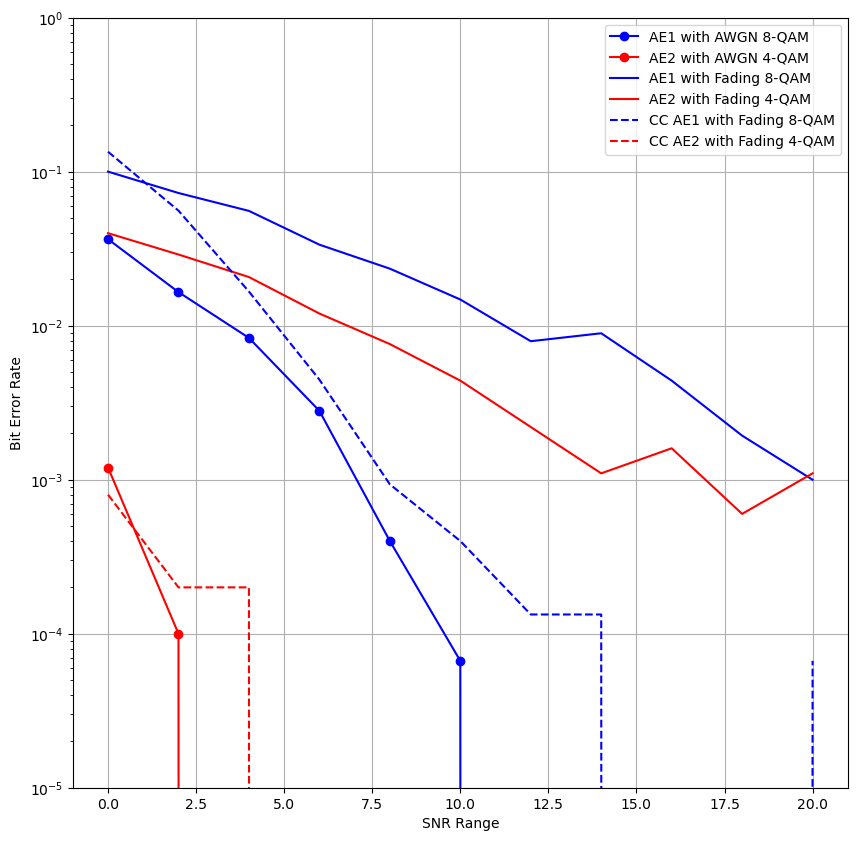

In [23]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.figure(figsize=(10, 10))
plt.plot(EbNodB_range, ber1_awgn, 'bo-',label=f'AE1 with AWGN {M1}-QAM')
plt.plot(EbNodB_range, ber2_awgn, 'ro-',label=f'AE2 with AWGN {M2}-QAM')
plt.plot(EbNodB_range, ber1, 'b',label=f'AE1 with Fading {M1}-QAM')
plt.plot(EbNodB_range, ber2, 'r',label=f'AE2 with Fading {M2}-QAM')
plt.plot(EbNodB_range, ber1_conv, 'b--',label=f'CC AE1 with Fading {M1}-QAM')
plt.plot(EbNodB_range, ber2_conv, 'r--',label=f'CC AE2 with Fading {M2}-QAM')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Bit Error Rate')
plt.ylim([10**-5, 1])
plt.grid()
plt.legend(loc='upper right',ncol = 1)